In [2]:
BASE_PROJECT_DIR = '/home/akhanal1/ature'
BASE_PROJECT_DIR = '/home/ak/PycharmProjects/ature'

import os
import sys
import traceback
import six

sys.path.append(BASE_PROJECT_DIR)
os.chdir(BASE_PROJECT_DIR)

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from utils import img_utils as iu
sep = os.sep
import torch
import math
%load_ext autoreload
%autoreload 2
from PIL import Image as IMG
import utils.img_utils as iu
from commons.IMAGE import Image
import json
from skimage.morphology import skeletonize_3d
from scipy.ndimage.measurements import label

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import neuralnet.utils.auto_split as asp
from neuralnet.utils.measurements import get_best_thr

from neuralnet.unet.runs import DRIVE as DRIVE
# from neuralnet.thrnet.runs import DRIVE
# from neuralnet.unet.runs import DRIVE
import operator

In [10]:
split_file = DRIVE['Dirs']['splits_json'] + os.sep + 'UNET-DRIVE.chk.tar.json'
split = json.load(open(split_file))

checks = np.arange(125,200, 5)
f1 = {}
for c in checks:
    f1[c] = 0

In [82]:

dff = pd.DataFrame(f1_data.copy(), columns=header)

In [9]:
np.arange(125,200, 5)

array([125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185,
       190, 195])

In [11]:
for file in split['test']:
    imap = Image()
    imap.load_file('data/DRIVE/crazynet_logs',  file.split('.')[0]+'.png')
    imap.working_arr = imap.image_arr
    imap.load_ground_truth(DRIVE['Dirs']['truth'], DRIVE['Funcs']['truth_getter'])
    imap.load_mask(DRIVE['Dirs']['mask'], DRIVE['Funcs']['mask_getter'])
    imap.apply_mask()
    for th in checks:
        ig = imap.working_arr.copy()
        ig[ig>th] = 255
        ig[ig<=th] = 0
        prf1a =  iu.get_praf1(ig, imap.ground_truth)
#         print(prf1a)
        f1[th] += prf1a['F1']

In [15]:
f1

{125: 16.03838,
 130: 15.987779999999997,
 135: 15.957510000000001,
 140: 15.921880000000002,
 145: 15.878129999999999,
 150: 15.8319,
 155: 15.78123,
 160: 15.72206,
 165: 15.654999999999998,
 170: 15.585760000000002,
 175: 15.509390000000002,
 180: 15.42312,
 185: 15.324180000000002,
 190: 15.22115,
 195: 15.098779999999998}

In [17]:
from scipy.signal import savgol_filter

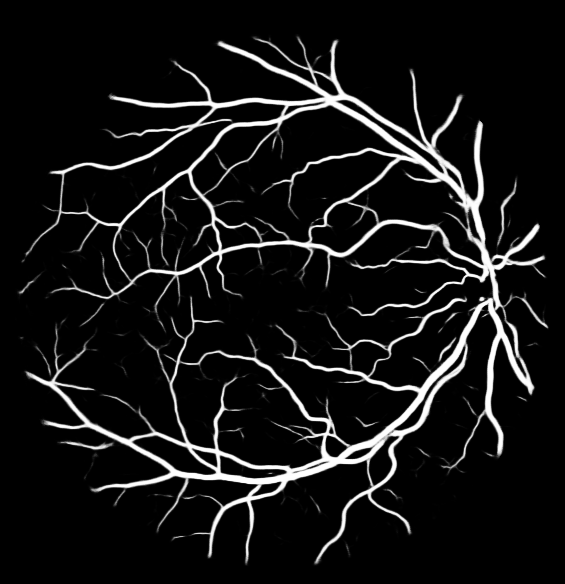

In [65]:
IMG.fromarray(imap.working_arr)

In [16]:
def get_prf1a_for_patch(img_obj, shape):
    indices = iu.get_chunk_indexes(img_obj.working_arr.shape, shape, shape)
    thrp = np.zeros_like(img_obj.working_arr.copy())
    for p, q, r, s in indices:
        patch = img_obj.working_arr[p:q,r:s].copy()
        y = img_obj.ground_truth[p:q, r:s].copy()
        t = get_best_thr(patch, y)[1] 
        patch[patch>t] = 255
        patch[patch<=t] = 0
        thrp[p:q,r:s] = patch
    thrp[img_obj.mask==0]=0
    return iu.get_praf1(thrp, img_obj.ground_truth)

### Compute global best thr, per image thr and per patch thr

In [17]:
header = ['FILE','UNET_PRED','GLOBAL_THR','PER_IMG_THR','PATCH16_THR','PATCH32_THR','PATCH64_THR']
f1_data = []
prec_data = []
rec_data = []
acc_data = []
for file in split['test']:
    imap = Image()
    imap.load_file(DRIVE['Dirs']['logs'],  file.split('.')[0]+'.png')
    imap.working_arr = imap.image_arr
    imap.load_ground_truth(DRIVE['Dirs']['truth'], DRIVE['Funcs']['truth_getter'])
    imap.load_mask(DRIVE['Dirs']['mask'], DRIVE['Funcs']['mask_getter'])
    imap.apply_mask()
    
    unet_img = iu.get_image_as_array(image_file='data/DRIVE/unet_logs_pred/'+'pred_'+file.split('.')[0]+'.png', channels=1)
    unet_pred = iu.get_praf1(unet_img, imap.ground_truth)
    
    ig = imap.working_arr.copy()
    ig[ig>125] = 255
    ig[ig<=125] = 0
    global_thr =  iu.get_praf1(ig, imap.ground_truth)
    
    per_img = get_best_thr(imap.working_arr.copy(), imap.ground_truth)[0]
    patch_16 = get_prf1a_for_patch(imap.__copy__(), (16,16))
    patch_32 = get_prf1a_for_patch(imap.__copy__(), (32,32))
    patch_64 = get_prf1a_for_patch(imap.__copy__(), (64,64))
    
    f1_data.append([file,unet_pred['F1'] ,global_thr['F1'], per_img['F1'], patch_16['F1'], patch_32['F1'], patch_64['F1']])
    prec_data.append([file, unet_pred['Precision'], global_thr['Precision'], per_img['Precision'], patch_16['Precision'], patch_32['Precision'], patch_64['Precision']])
    rec_data.append([file, unet_pred['Recall'], global_thr['Recall'], per_img['Recall'], patch_16['Recall'], patch_32['Recall'], patch_64['Recall']])
    acc_data.append([file, unet_pred['Accuracy'], global_thr['Accuracy'], per_img['Accuracy'], patch_16['Accuracy'], patch_32['Accuracy'], patch_64['Accuracy']])

### F1 Score

In [29]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

/home/ak/anaconda3/envs/ature_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


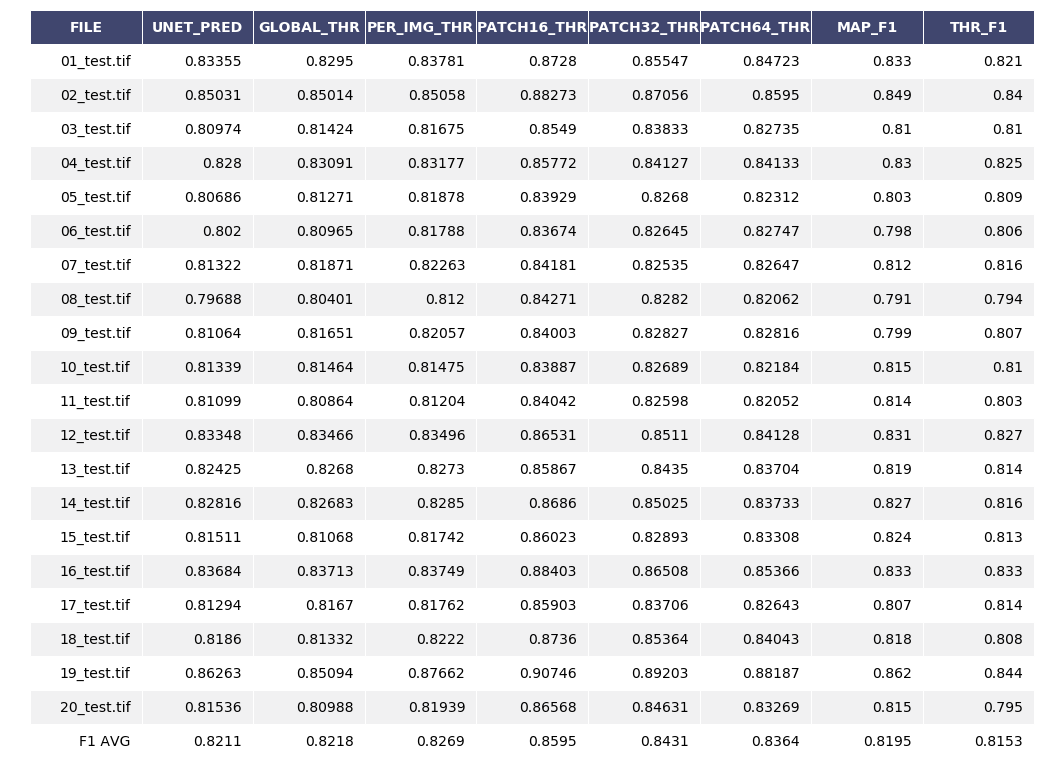

In [94]:
test_mapnet = 'data/DRIVE_MAP/mapnet_logs/MAPNET-DRIVE-TEST.csv'
df_map = pd.read_csv(test_mapnet)
df_map = df_map.sort_values('FILE', inplace=False)

test_thrnet = 'data/DRIVE_MAP/thrnet_logs/THRNET-DRIVE-TEST.csv'
df_thr = pd.read_csv(test_thrnet)
df_thr = df_thr.sort_values('FILE', inplace=False)

df = pd.DataFrame(f1_data.copy(), columns=header)
df.sort_values('FILE',inplace=True, ascending=True)

df = df.join(df_map['MAP_F1'].round(4))
df = df.join(df_thr['THR_F1'].round(4))

df.loc['AVG'] = df.mean().round(4)
df.set_value('AVG', 'FILE', 'F1 AVG')
render_mpl_table(df, header_columns=0, col_width=2.0)
plt.savefig('F1_SUMMARY.png')

### Accuracy

In [76]:
df.set_value('AVG', 'FILE')

TypeError: __call__() takes from 1 to 2 positional arguments but 3 were given

In [73]:
df

,FILE,UNET_PRED,GLOBAL_THR,PER_IMG_THR,PATCH16_THR,PATCH32_THR,PATCH64_THR
5,01_test.tif,0.83405,0.82728,0.83447,0.87290,0.85540,0.84543
1,02_test.tif,0.84950,0.84876,0.84926,0.88225,0.86625,0.85787
11,03_test.tif,0.80677,0.81395,0.81812,0.85566,0.83625,0.82861
3,04_test.tif,0.82706,0.83158,0.83358,0.86458,0.84809,0.84188
16,05_test.tif,0.81322,0.81061,0.81672,0.83858,0.82477,0.82205
8,06_test.tif,0.80189,0.80591,0.81359,0.83624,0.82578,0.82080
12,07_test.tif,0.81981,0.82062,0.82390,0.85128,0.83166,0.83140
7,08_test.tif,0.79851,0.80040,0.80496,0.84201,0.82214,0.81587
13,09_test.tif,0.81609,0.80816,0.81514,0.84612,0.82633,0.82383
17,10_test.tif,0.81597,0.81488,0.81552,0.84314,0.82746,0.82338


In [110]:
iu.get_praf1(unet_img, imap.ground_truth)

{'Accuracy': 0.97061, 'F1': 0.81404, 'Precision': 0.7612, 'Recall': 0.87476}

In [2]:
from neuralnet.unet import runs

In [57]:
wide_files = os.listdir(runs.VEVIO['Dirs']['image'])

In [58]:
import json

In [28]:
folds = []
for i in range(0, 30, 5):
    test = wide_files[i:i+5]
    print(len(test))
    t_val = [item for item in wide_files if item not in test]
    validation = t_val[0:4]
    train = [item for item in t_val if item not in validation]
    configuration = {
        'train': train,
        'validation': validation,
        'test': test
    }
    folds.append(configuration)

5
5
5
5
5
5


In [34]:
tt = []
for f in folds:
    tt+=f['test']

In [39]:
import random

In [41]:
sorted(wide_files)

['wide_image_01.png',
 'wide_image_02.png',
 'wide_image_03.png',
 'wide_image_04.png',
 'wide_image_05.png',
 'wide_image_06.png',
 'wide_image_07.png',
 'wide_image_08.png',
 'wide_image_09.png',
 'wide_image_10.png',
 'wide_image_11.png',
 'wide_image_12.png',
 'wide_image_13.png',
 'wide_image_14.png',
 'wide_image_15.png',
 'wide_image_16.png',
 'wide_image_17.png',
 'wide_image_18.png',
 'wide_image_19.png',
 'wide_image_20.png',
 'wide_image_21.png',
 'wide_image_22.png',
 'wide_image_23.png',
 'wide_image_24.png',
 'wide_image_25.png',
 'wide_image_26.png',
 'wide_image_27.png',
 'wide_image_28.png',
 'wide_image_29.png',
 'wide_image_30.png']

In [44]:
a =26

In [50]:
str(chr(int(a)))

'\x1a'

In [51]:
import neuralnet.utils.auto_split as asp

In [60]:
asp.create_splits(wide_files, 4, 4, file_name='UNET-VEVIO.chk.tar.json')

4
4
4
4


In [306]:
    df = None
    def plott_loss(file=None, key='LOSS', query=None, title=None, save=False):
        df = pd.read_csv(file).query(query) if query else pd.read_csv(file)
        batches_per_epoch = df.shape[0] / df['EPOCH'].max() if 'EPOCH1' in df.columns else 1
        print('EPOCH' in df.columns)
        df_sv = df.copy()
        df_sv[key] = savgol_filter(df_sv[key], 51, 3)

        plt.rcParams["figure.figsize"] = [18, 6]
        fig, ax1 = plt.subplots(nrows=1, ncols=1)
        df.plot(y=key, c='#cccccc', ax=ax1, title=title)
        df_sv.plot(y=key, c='#222222', ax=ax1, title=title)
        
        if batches_per_epoch is not None:
            ticks = [int(a) for a in ax1.get_xticks()//batches_per_epoch]
            ax1.xaxis.set_ticklabels(ticks)
        
        ax1.set_xlabel('Epochs')
        if save:
            plt.savefig('FIRSTPLOT1.png')
        else:
            plt.show()

In [80]:
os.listdir(DRIVE['Dirs']['logs'])

['10THRNET-DRIVE.json.tar-TRAIN.csv', '0THRNET-DRIVE.json.tar-TRAIN.csv']

In [215]:
file = DRIVE['Dirs']['logs'] + '/' + "0THRNET-DRIVE.json.tar-TRAIN.csv"

True


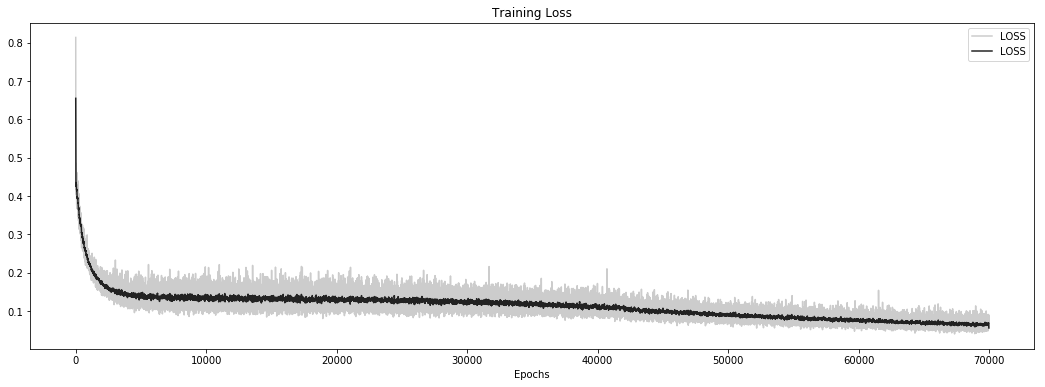

In [307]:
plott_loss(file=file, query='TYPE==0', title='Training Loss', save=True)

In [87]:
np.arange(0, 100, 1.0)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [92]:
range(0, 10,1)

range(0, 10)

In [186]:
69600/200

348.0

In [230]:
int(70000/348)

201

In [255]:
df.shape()

AttributeError: 'NoneType' object has no attribute 'shape'

In [288]:
plt.savefig('1.png')

In [301]:
False + False

0

In [308]:
min(1,2,3)

1

In [336]:
from random import randint

In [354]:
print(randint(-30, 30))

10


In [381]:
a = torch.FloatTensor(2).random_(-55, 55)

In [405]:
b =torch.rand(2,4,3,3)

In [406]:
b+a

RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 3

In [408]:
b+x2

tensor([[[[-14.2746, -14.8733, -14.8130],
          [-14.2420, -14.9135, -14.3104],
          [-14.1528, -14.1496, -14.9184]],

         [[-14.3234, -14.6877, -14.7296],
          [-14.4627, -14.6027, -14.9720],
          [-14.2577, -14.6665, -14.0893]],

         [[-14.1761, -14.6228, -14.5445],
          [-14.3289, -14.8426, -14.3224],
          [-14.6973, -14.5610, -14.4617]],

         [[-14.8960, -14.8870, -14.7608],
          [-14.4223, -14.9961, -14.5839],
          [-14.1223, -14.8287, -14.1354]]],


        [[[-22.7633, -22.4077, -22.3704],
          [-22.1679, -22.3987, -22.0017],
          [-22.8089, -22.3171, -22.4793]],

         [[-22.7317, -22.5928, -22.9203],
          [-22.3178, -22.1540, -22.1098],
          [-22.1349, -22.8309, -22.8506]],

         [[-22.1184, -22.0163, -22.1093],
          [-22.3674, -22.2490, -22.7899],
          [-22.8865, -22.9744, -22.3796]],

         [[-22.5703, -22.1648, -22.2610],
          [-22.0557, -22.4457, -22.7347],
          [-22.260

In [411]:
b

tensor([[[[ 0.7254,  0.1267,  0.1870],
          [ 0.7580,  0.0865,  0.6896],
          [ 0.8472,  0.8504,  0.0816]],

         [[ 0.6766,  0.3123,  0.2704],
          [ 0.5373,  0.3973,  0.0280],
          [ 0.7423,  0.3335,  0.9107]],

         [[ 0.8239,  0.3772,  0.4555],
          [ 0.6711,  0.1574,  0.6776],
          [ 0.3027,  0.4390,  0.5383]],

         [[ 0.1040,  0.1130,  0.2392],
          [ 0.5777,  0.0039,  0.4161],
          [ 0.8777,  0.1713,  0.8646]]],


        [[[ 0.2367,  0.5923,  0.6296],
          [ 0.8321,  0.6013,  0.9983],
          [ 0.1911,  0.6829,  0.5207]],

         [[ 0.2683,  0.4072,  0.0797],
          [ 0.6822,  0.8460,  0.8902],
          [ 0.8651,  0.1691,  0.1494]],

         [[ 0.8816,  0.9837,  0.8907],
          [ 0.6326,  0.7510,  0.2101],
          [ 0.1135,  0.0256,  0.6204]],

         [[ 0.4297,  0.8352,  0.7390],
          [ 0.9443,  0.5543,  0.2653],
          [ 0.7393,  0.0415,  0.6511]]]])

In [407]:
x2 = a.unsqueeze(1).unsqueeze(2).unsqueeze(3)

In [394]:
x2.shape

torch.Size([2, 1, 1, 1])

In [402]:
x2.shape

torch.Size([2, 1, 1, 1])

In [428]:
a = torch.rand((64,2))
b = torch.rand((64, 2))

In [429]:
a.sum(1).shape

torch.Size([64])

In [439]:
torch.cat([a.sum(1)[...,None], b, b], 1).shape

torch.Size([64, 5])

In [440]:
a[:,0].shape

torch.Size([64])

In [26]:
import six